In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ccpca import CCPCA
from opt_sign_flip import OptSignFlip
from mat_reorder import MatReorder
import pandas as pd

from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
# from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

from os import listdir
from os.path import isfile, join

from state import State
from hatchet import *

import json

In [2]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format

In [43]:
dirname = '/home/vidi/Work/llnl/CallFlow/.callflow'
dataset = 'osu'
dataset_dirname = '/home/vidi/Work/llnl/CallFlow/data/osu/' 

In [70]:
def read_gf(name):
    state = State()
    df_filepath = dirname + '/' + name +  '/filter_df.csv'
    entire_df_filepath = dirname + '/' + name + '/entire_df.csv'
    graph_filepath = dirname + '/' + name + '/filter_graph.json'
    entire_graph_filepath = dirname + '/' + name + '/entire_graph.json'   
    group_df_filepath = dirname + '/' + name + '/group_df.csv'
    parameters_filepath = dataset_dirname +  name + '/env_params.txt'

    with open(graph_filepath, 'r') as graphFile:
        data = json.load(graphFile)

    state.gf = GraphFrame()
    state.gf.from_literal_persist(data)

    with open(entire_graph_filepath, 'r') as entire_graphFile:
        entire_data = json.load(entire_graphFile)
            
    state.entire_gf = GraphFrame()
    state.entire_gf.from_literal_persist(entire_data)

    state.df = pd.read_csv(df_filepath)
    state.entire_df = pd.read_csv(entire_df_filepath)

    state.graph = state.gf.graph
    state.entire_graph = state.entire_gf.graph

    # replace df['node'] from str to the Node object.
    state.df = replace_str_with_Node(state.df, state.graph)
    state.entire_df = replace_str_with_Node(state.entire_df, state.entire_graph)
    
    state.group_df = pd.read_csv(group_df_filepath)
    state.params =  {}
    for line in open(parameters_filepath, 'r'):
        s = 0
        for num in line.strip().split(','):
            split_num = num.split('=')
            state.params[split_num[0]] = split_num[1]
    return state

In [5]:
def replace_str_with_Node(df, graph):
        mapper = {}
        def dfs_recurse(root):
            for node in root.children: 
                mapper[node.callpath[-1]] = Node(node.nid, node.callpath, None)
                dfs_recurse(node)
        for root in graph.roots:
            mapper[root.callpath[-1]] = Node(root.nid, root.callpath, None)
            dfs_recurse(root)
        df['node'] = df['node'].apply(lambda node: mapper[node] if node in mapper else '')
        return df

In [34]:
def read_datasets(name):
    files = listdir(dirname)
    ret = []
    for file in files:
        if(file.split('.')[0] == 'osu_bcast'):
            ret.append(file)
    return ret

In [ ]:
def add_dataset_params(state):
    ret = {}
    ret['max_inclusive_time'] = state.df['time (inc)'].max()
    ret['max_exclusive_time'] = state.df['time'].max()
    ret['rank_count'] = len(state.df['rank'].unique())
    return ret

In [92]:
datasets = read_datasets(dataset)
states = {}
count = 100
for idx, dataset_name in enumerate(datasets[0:count]):
    print(dataset_name)
    state = read_gf(dataset_name)
    states[dataset_name] = state
    performance_params = add_dataset_params(state)
    states[dataset_name].params.update(performance_params)

osu_bcast.1.12.2019-09-04_00-32-11
osu_bcast.1.16.2019-09-03_11-28-08
osu_bcast.1.10.2019-09-04_07-05-12
osu_bcast.1.16.2019-09-04_01-36-36
osu_bcast.1.10.2019-09-03_23-33-03
osu_bcast.1.10.2019-09-04_08-07-45
osu_bcast.1.10.2019-09-03_13-07-55
osu_bcast.1.16.2019-09-03_15-11-44
osu_bcast.1.10.2019-09-04_03-18-07
osu_bcast.1.16.2019-09-04_02-34-43
osu_bcast.1.14.2019-09-03_11-23-27
osu_bcast.1.14.2019-09-03_14-11-29
osu_bcast.1.16.2019-09-03_19-04-47
osu_bcast.1.10.2019-09-03_21-42-03
osu_bcast.1.10.2019-09-03_11-12-50
osu_bcast.1.16.2019-09-03_17-03-10
osu_bcast.1.16.2019-09-03_14-16-10
osu_bcast.1.10.2019-09-04_06-10-08
osu_bcast.1.10.2019-09-04_04-14-14
osu_bcast.1.10.2019-09-04_02-21-56
osu_bcast.1.14.2019-09-03_15-07-03
osu_bcast.1.12.2019-09-03_19-51-19
osu_bcast.1.14.2019-09-04_07-13-20
osu_bcast.1.10.2019-09-03_14-59-00
osu_bcast.1.14.2019-09-03_16-58-17
osu_bcast.1.14.2019-09-03_22-45-35
osu_bcast.1.10.2019-09-03_15-54-46
osu_bcast.1.10.2019-09-04_01-23-49
osu_bcast.1.12.2019-

# Projection of the parameters of all runs

(<Figure size 576x576 with 1 Axes>,
 [])

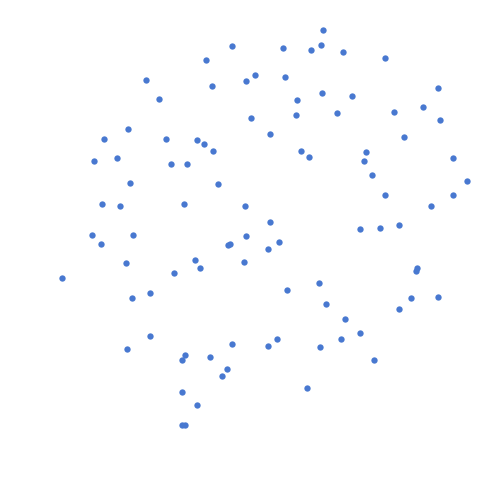

In [83]:
# params_df = pd.DataFrame(columns=states[datasets[0]].params.keys())
# print(params_df)
row_list = []
for idx, state in enumerate(states):
    row_list.append(states[state].params)
df = pd.DataFrame(row_list)
X = np.vstack([df.values.tolist()])
proj = TSNE(random_state=RS).fit_transform(X)
scatter(proj, [0])

In [86]:
print(df['rank_count'].unique())

[12 16 10 14 18]


# Projection of entire dataset

In [24]:
all_cols = ['node', 'rank', 'time (inc)', 'time', 'nid', 'rank.1', 'file', 'line',
       'module', 'name', 'node.1', 'type', 'n_index', 'mod_index', 'callees',
       'callers', 'show_node', 'vis_node_name', 'path']
cols = ['rank', 'time (inc)', 'time', 'nid', 'line',
       'module', 'name', 'type', 'callees',
       'callers', 'show_node', 'path']
selected_cols = ['rank', 'time (inc)', 'time', 'nid', 'line', 'name', 'module']

projections = []
for idx, state in enumerate(states):
    print("Getting projections for {0}: {1}".format(idx, state))
    df = states[state].df[selected_cols]
    df = df.groupby(['name']).mean()
    X = np.vstack([df.values.tolist()])
    proj = TSNE(random_state=RS).fit_transform(X)
    print("Projection shape", proj.shape)
    projections.append(proj)

Getting projections for 0: osu_bcast.1.12.2019-09-04_00-32-11
Projection shape (108, 2)
Getting projections for 1: osu_bcast.1.16.2019-09-03_11-28-08
Projection shape (110, 2)
Getting projections for 2: osu_bcast.1.10.2019-09-04_07-05-12
Projection shape (99, 2)
Getting projections for 3: osu_bcast.1.16.2019-09-04_01-36-36
Projection shape (108, 2)
Getting projections for 4: osu_bcast.1.10.2019-09-03_23-33-03
Projection shape (99, 2)
Getting projections for 5: osu_bcast.1.10.2019-09-04_08-07-45
Projection shape (96, 2)
Getting projections for 6: osu_bcast.1.10.2019-09-03_13-07-55
Projection shape (93, 2)
Getting projections for 7: osu_bcast.1.16.2019-09-03_15-11-44
Projection shape (105, 2)
Getting projections for 8: osu_bcast.1.10.2019-09-04_03-18-07
Projection shape (91, 2)
Getting projections for 9: osu_bcast.1.16.2019-09-04_02-34-43
Projection shape (112, 2)
Getting projections for 10: osu_bcast.1.14.2019-09-03_11-23-27
Projection shape (106, 2)
Getting projections for 11: osu_bcas

Projection shape (108, 2)
Getting projections for 93: osu_bcast.1.16.2019-09-04_05-27-13
Projection shape (107, 2)
Getting projections for 94: osu_bcast.1.16.2019-09-03_21-54-42
Projection shape (110, 2)
Getting projections for 95: osu_bcast.1.10.2019-09-04_05-14-33
Projection shape (101, 2)
Getting projections for 96: osu_bcast.1.10.2019-09-03_17-51-29
Projection shape (97, 2)
Getting projections for 97: osu_bcast.1.16.2019-09-04_06-22-45
Projection shape (108, 2)
Getting projections for 98: osu_bcast.1.10.2019-09-03_12-11-37
Projection shape (99, 2)
Getting projections for 99: osu_bcast.1.10.2019-09-03_20-45-50
Projection shape (102, 2)


In [25]:
y_projections = []
for idx, state in enumerate(states):
    df = states[state].df['module']
    Y = np.vstack([df.values.tolist()])
    y_projections.append(Y)

t:   5%|▌         | 5/100 [00:00<00:02, 39.78it/s, now=None]

MoviePy - Building file animation.gif with imageio.


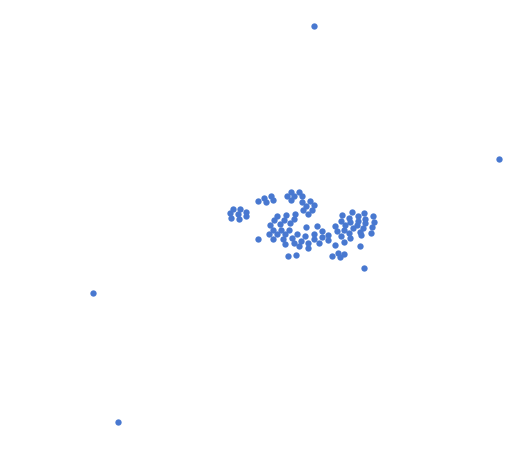

In [26]:
max_length = 0
for idx, projection in enumerate(projections):
    max_length = max(max_length, len(projection))
out_arr = []

for idx, projection in enumerate(projections):
    nan_arr = np.ones((np.max([len(ps) for ps in projection]),max_length))*np.nan
    for i,c in enumerate(projection):
        nan_arr[:len(c),i] = c
    out_arr.append(nan_arr.T)

X_iter = np.dstack(projection.reshape(-1, 2) for projection in out_arr)
f, ax, sc, txts = scatter(X_iter[..., -1], [0])

def make_frame_mpl(t):
    i = int(t)
    x = X_iter[..., int(i)]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
#         xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(100)
        txt.set_y(40)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/1)
animation.write_gif("animation.gif", fps=1)

In [12]:
digits = load_digits()
print(type(digits))
print(digits.target)
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
print(X)

<class 'sklearn.utils.Bunch'>
[0 1 2 ... 8 9 8]
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  1. ...  3.  0.  0.]
 [ 0.  0.  3. ...  4.  0.  0.]
 ...
 [ 0.  0.  4. ...  9.  0.  0.]
 [ 0.  0.  4. ...  9.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]]


In [13]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [14]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 1))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    x_values = [i for i in x[:, 0] if i != 'nan']
    y_values = [j for j in x[:, 1] if j != 'nan']
    sc = ax.scatter(x_values, y_values, lw=0, s=40)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
#     for i in range(10):
#         # Position of each label.
#         xtext, ytext = np.median(x[colors == i, :], axis=0)
#         txt = ax.text(xtext, ytext, str(i), fontsize=24)
#         txt.set_path_effects([
#             PathEffects.Stroke(linewidth=5, foreground="w"),
#             PathEffects.Normal()])
#         txts.append(txt)

    return f, ax, sc, txts

osu_bcast.1.16.2019-09-04_01-36-36


(<Figure size 576x576 with 1 Axes>,
 [])

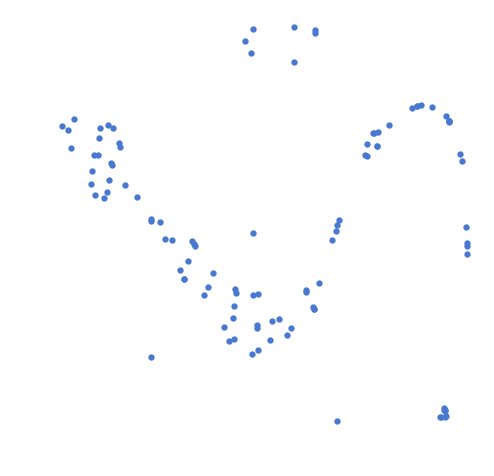

In [32]:
print(datasets[3])
scatter(projections[3], [0])

In [ ]:
#
# Example 1 (ccPCA result with Wine dataset)
#

In [ ]:
dataset_name = "wine"
data = np.loadtxt(
        open("./sample_data/" + dataset_name + ".csv", "rb"),
        delimiter=",",
        skiprows=1)
feature_names = np.genfromtxt(
    "./sample_data/" + dataset_name + ".featurenames.csv",
    delimiter=",",
    dtype='str')

# last 3 columens are cluster label, t-SNE's x-, and y-coord
X = data[:, :-3]
y = np.int_(data[:, -3])
print(data)

In [ ]:
df = pd.read_csv('./sample_data/wine.csv')
print(df)

In [ ]:
target_label = 0

# apply ccpca
ccpca = CCPCA(n_components=2)
ccpca.fit(
    X[y == target_label],
    X[y != target_label],
    var_thres_ratio=0.5,
    n_alphas=40,
    max_log_alpha=0.5)

# get results
cpca_result = ccpca.transform(X)
best_alpha = ccpca.get_best_alpha()
cpca_fcs = ccpca.get_feat_contribs()

In [ ]:
# print and plot results
print("best alpha: ", best_alpha)
print("feature contributions: ",cpca_fcs)
plt.figure()
plt.scatter(
    cpca_result[y == target_label, 0],
    cpca_result[y == target_label, 1],
    color='navy',
    alpha=.5,
    label="Label" + str(target_label))
plt.scatter(
    cpca_result[y != target_label, 0],
    cpca_result[y != target_label, 1],
    color='gray',
    alpha=.5,
    label="Others")
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

In [ ]:
#
# Example 2 (features' contributions view with Community & Crime dataset)
#

In [ ]:
dataset_name = "crime"
data = np.loadtxt(
        open("./sample_data/" + dataset_name + ".csv", "rb"),
        delimiter=",",
        skiprows=1)
feature_names = np.genfromtxt(
    "./sample_data/" + dataset_name + ".featurenames.csv",
    delimiter=",",
    dtype='str')

X = data[:, :-3]
y = np.int_(data[:, -3])
unique_labels = np.unique(y)

In [ ]:
_, n_feats = X.shape
n_labels = len(unique_labels)
first_cpc_mat = np.zeros((n_feats, n_labels))
feat_contrib_mat = np.zeros((n_feats, n_labels))

# 1. get the scaled feature contributions and first cPC for each label
ccpca = CCPCA(n_components=1)
for i, target_label in enumerate(unique_labels):
    ccpca.fit(
        X[y == target_label],
        X[y != target_label],
        var_thres_ratio=0.5,
        n_alphas=40,
        max_log_alpha=0.5)

    first_cpc_mat[:, i] = ccpca.get_first_component()
    feat_contrib_mat[:, i] = ccpca.get_scaled_feat_contribs()

# 2. apply optimal sign flipping
OptSignFlip().opt_sign_flip(first_cpc_mat, feat_contrib_mat)

# 3. apply hierarchical clustering with optimal-leaf-ordering
mr = MatReorder()
mr.fit_transform(feat_contrib_mat)

# 4. apply aggregation
n_feats_shown = 25
agg_feat_contrib_mat, label_to_rows, label_to_rep_row = mr.aggregate_rows(feat_contrib_mat,
                                                                          n_feats_shown,
                                                                          agg_method='abs_max')

In [ ]:
# plot result

# plot heatmap
fig, ax = plt.subplots(figsize=(8, 12))
im = ax.imshow(agg_feat_contrib_mat, cmap='coolwarm', aspect='auto')

# plot cluster names
xlabel_names = [None] * n_labels
for i, col in enumerate(mr.order_col_):
    xlabel_names[i] = 'Label ' + str(unique_labels[col])
ax.set_xticks(np.arange(n_labels))
ax.set_xticklabels(xlabel_names)

# plot feature names
ylabel_names = np.array(feature_names)[mr.order_row_]
ylabel_names = np.array(feature_names, dtype=object)[label_to_rep_row]
for i in range(len(ylabel_names)):
    name = ylabel_names[i]
    rows = label_to_rows[i]
    if len(rows) > 1:
        ylabel_names[i] = name + ', ' + str(len(rows) - 1) + ' more'
ax.set_yticks(np.arange(min(n_feats_shown, n_feats)))
ax.yaxis.tick_right()
ax.set_yticklabels(ylabel_names, fontsize=28)

# rotate the tick labels
xlbls = ax.get_xticklabels()
plt.setp(xlbls, rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()